SYNTHETIC NET ANALYSIS - MIXED FORMULATION

This notebook is used to divide in a specific number of REV the synthetic cubic network given as input, to compute the upscaled parameters and to solve the mixed final coupled problem, computing both the pressure and the velocity of the blood flow.

In [29]:
import time
from scipy.sparse import *
from dolfin import *
from block import *
from xii import *
import numpy as np
import matplotlib.pyplot as plt
import auxiliary_functions as aux
from scipy.sparse.linalg import *
from petsc4py import PETSc


Mesh import

In [30]:
meshQ = Mesh()

mesh_name='888_mesh/888_marked_mesh.xdmf'
markers_name="888_mesh/888_markers.xdmf"
     
with XDMFFile(mesh_name) as infile:

     infile.read(meshQ)


C_markers = MeshFunction('size_t', meshQ , 0)
xdmf_file = XDMFFile(markers_name)  

xdmf_file.read(C_markers)
xdmf_file.close()

REV division process and computation of the Upscaled Parameters

In [31]:
n_div_x=2
n_div_y=2
n_div_z=2
p_in =7000
p_out=5000
min_val = 5  # Minimum value
max_val = 12 

radii=aux.generate_radom_raddii(meshQ,min_val,max_val)

#print(radii)
radii_not_scaled=radii*1e-6
dir_results = '/mnt/c/Users/franc/Desktop/MIXED_SYNTHETIC_NET'

K_x,K_y,K_z,C,mu_bl_up = aux.REV_division('CapillaryMesh',dir_results,meshQ,radii_not_scaled, C_markers,n_div_x,n_div_y,n_div_z,p_in,p_out,plot_mesh_flag=False, M_plot_flag=False,lap_plot_flag=False)


-------------------- MESH INFO --------------------
Coordinates: (5556, 3)
Edges: (6254, 2)
Radii: (6254,)
Labels: (5556,)
Interior Points: (5226,)
Inlet Points: (165,)
Outlet Points: (165,)

Total REV number: 8
451
783
515
826
708
819
698
756
-------------------- COMPUTING INTERSECTIONS --------------------
Coordinates with intersections: (5868, 3)
Edges with intersections: (6566, 2)
Labels with intersections: (5868,)
Radii with intersections: (6566,)

... COMPUTING K VALUES  ...

------------------------------------------------- DIRECTION: 1  -------------------------------------------------
-------------------------------------------------------------------------
REV = 1
(519, 2)
(519,)
-------------------- SUBMESH INFO --------------------
Coordinates: (408, 3)
Edges: (429, 2)
Labels: (408,)
Inlet points submesh: 21
Outlet points submesh: 35
Number of vertices: 408
Number of cells: 429
1 x
Solving linear variational problem.
-7.844961885219635e-15
-1.1989571104790168e-14
1.35802817

In [32]:
#RHS TERM
formatted_vector = ['{:.2e}'.format(value) for value in C]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)

[1.36e-06, 2.47e-06, 1.88e-06, 2.63e-06, 2.61e-06, 2.67e-06, 2.32e-06, 2.34e-06]


In [33]:
#UPSCALED PERMEABILITY TENSOR
formatted_vector = ['{:.2e}'.format(value) for value in K_x]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)
formatted_vector = ['{:.2e}'.format(value) for value in K_y]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)
formatted_vector = ['{:.2e}'.format(value) for value in K_z]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)

[7.84e-15, 1.23e-14, 1.02e-14, 2.73e-14, 1.96e-14, 1.23e-14, 8.03e-15, 1.26e-14]
[4.47e-15, 2.34e-14, 1.84e-14, 1.75e-14, 1.74e-14, 2.4e-14, 2.06e-14, 1.36e-14]
[1.41e-14, 2.43e-14, 1.05e-14, 2.37e-14, 1.81e-14, 1.2e-14, 2.33e-14, 1.35e-14]


In [34]:
#UPSCALED BLOOD VISCOSITY
formatted_vector = ['{:.2e}'.format(value) for value in mu_bl_up]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)


[0.00397, 0.00385, 0.00388, 0.00392, 0.00388, 0.00391, 0.00391, 0.00387]


Functions used to create the mesh and to build the problem

In [35]:
def get_mesh(n, coupling_radius,n_div_x,n_div_y,n_div_z):
     ''' Function that creates the cubic capillary and tissue meshes with respective boundary tags.
          INPUT:
               n : parameter that determines the size of the boxmesh.
               coupling_radius : parameter to reduce the mesh size at the boundary.
               n_div_x : number of division in the x direction.
               n_div_y : number of division in the y direction.
               n_div_z : number of division in the z direction.

          OUTPUT:
               meshV : cubic mesh of the region.
               Q_markers : markers for the capillary boundary points.
               V_markers : markers fot the tissue boundary points.


     '''
     #--------------------MESHES-------------------------

     #3D mesh Tissue mesh
     inf_point = Point(-1 - 1*coupling_radius, -1 - 1*coupling_radius, -1 - 1*coupling_radius)
     max_point = Point(1 + 1*coupling_radius, 1 + 1*coupling_radius, 1 + 1*coupling_radius)
     meshV = BoxMesh(inf_point, max_point, n, n, n)
     coord_V=meshV.coordinates()

     tol=1e-5
     labels_V=555*np.ones(np.shape(coord_V)[0],)

     indx=np.where(np.abs(coord_V[:,0]-np.min(coord_V[:,0]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,0]-np.max(coord_V[:,0]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,1]-np.max(coord_V[:,1]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,2]-np.max(coord_V[:,2]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,1]-np.min(coord_V[:,1]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,2]-np.min(coord_V[:,2]))<=tol)[0]
     labels_V[indx]=111

     V_markers = MeshFunction('size_t', meshV, 0)

     V_markers.array()[:]=labels_V

     file = XDMFFile(f"{dir_results}/FINAL_RESULTS/MARKERS/V_markers.xdmf")
     file.write(V_markers)

     REV_labels_t=aux.compute_REV_labels(meshV,n_div_x,n_div_y,n_div_z)

     REV_markers_t = MeshFunction('size_t', meshV, 0)


     #Per ogni punto della mesh del tessuto ho i tag da 1 a 8 che mi indicano a quale REV appartiene
     REV_markers_t.array()[:]=REV_labels_t
     #print(REV_labels_t)

     file = XDMFFile(f"{dir_results}/FINAL_RESULTS/MARKERS/REV_markers.xdmf")
     file.write(REV_markers_t)

     #--------------------------------------------------

     #Capillary mesh

     tol=1e-5
     labels_Q=555*np.ones(np.shape(coord_V)[0],)

     indx=np.where(np.abs(coord_V[:,0]-np.min(coord_V[:,0]))<=tol)[0]
     labels_Q[indx]=111

     indx=np.where(np.abs(coord_V[:,0]-np.max(coord_V[:,0]))<=tol)[0]
     labels_Q[indx]=999

     indx=np.where(np.abs(coord_V[:,1]-np.min(coord_V[:,1]))<=tol)[0]
     labels_Q[indx]=111

     indx=np.where(np.abs(coord_V[:,1]-np.max(coord_V[:,1]))<=tol)[0]
     labels_Q[indx]=999

     indx=np.where(np.abs(coord_V[:,2]-np.min(coord_V[:,2]))<=tol)[0]
     labels_Q[indx]=111
     
     indx=np.where(np.abs(coord_V[:,2]-np.max(coord_V[:,2]))<=tol)[0]
     labels_Q[indx]=999

     print(type(labels_Q))

     Q_markers = MeshFunction('size_t', meshV, 0)

     Q_markers.array()[:]=labels_Q

     file = XDMFFile(f"{dir_results}/FINAL_RESULTS/MARKERS/Q_markers.xdmf")
     file.write(Q_markers)

     
     coord_V=meshV.coordinates()

     fig = plt.figure(figsize=(8, 6))
     ax = fig.add_subplot(111, projection='3d')
     scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=REV_markers_t.array())
     cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
     plt.title('REV division markers')


     fig = plt.figure(figsize=(8, 6))
     ax = fig.add_subplot(111, projection='3d')
     scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=V_markers.array())
     cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
     plt.title('Boundary markers for the tissue mesh')

     

     fig = plt.figure(figsize=(8, 6))
     ax = fig.add_subplot(111, projection='3d')
     scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=Q_markers.array())
     cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
     plt.title('Boundary markers for the capillary mesh')


     #Measures

     ds = Measure('ds', domain=meshV)
     ds = ds(subdomain_data=Q_markers)

     dst = Measure('ds', domain=meshV)
     dst = dst(subdomain_data=V_markers)

     #dx = Measure('dx', domain=meshQ)
     #dxt = Measure('dx', domain=meshV)

     # dxREV = Measure('dx', domain=meshQ)
     # dxREV = dxREV(subdomain_data=REV_markers)

     dxtREV = Measure('dx', domain=meshV)
     dxtREV = dxtREV(subdomain_data=REV_markers_t)

     return meshV, Q_markers, V_markers, REV_markers_t

def get_system(meshV, K_x, K_y, K_z, C, mu_bl_up, beta_value, p0_value):
    ''' Function that assemble the matrices to solve the problem
          INPUT:
               meshV : mesh of the cubic geometry.
               K_x :  x components of the permeability tensor, one for each REV.
               K_y :  y components of the permeability tensor, one for each REV.
               K_z :  z components of the permeability tensor, one for each REV.
               C : RHS terms, one for each REV.
               mu_bl_up : upscaled blood viscosity terms, one for each REV.
               beta_value :  Neumann parameter fot the tissue.
               p0_value : initial reference pressure value for the tissue.

            OUTPUT:
                AD : stiffness matrix.
                b : RHS term
                W : space of the solutions.
      
    '''
    # Spaces
    nRev=8

    V = VectorFunctionSpace(meshV, 'CG', 2, 3)
    Q = FunctionSpace(meshV, 'CG', 1)
    W = (V, Q)

    ucap, pcap = map(TrialFunction, W)
    vcap, qcap= map(TestFunction, W)
    ut, pt = map(TrialFunction, W)
    vt, qt= map(TestFunction, W)

    

      #----------------------------------------------------------
     
    #Parameters

    rho_bl = Constant(1030) #kg/m^3
    rho_int = Constant(1000) #kg/m^3
    mu_int= Constant(1.3*1e-3) #Pa * s
    k_t = Constant(1e-18) #m^2
    K_T=Constant(rho_int*k_t/mu_int)

    pi_p = Constant(3300)
    pi_int=Constant(666)
    p0 = Constant(p0_value)
  
    
    beta = Constant(beta_value)
  

    n = FacetNormal(meshV)
    
      #-------------------------------------------------------------------

    class Kinv(UserExpression):

        def __init__(self, mesh, REV_division, nRev, K_x, K_y, K_z,**kwargs):
            super().__init__()
            self.REV_division = REV_division
            self.nRev=nRev
            self.K_x = K_x
            self.K_y = K_y
            self.K_z = K_z
            self.mu_bl_up_x = mu_bl_up
            self.mu_bl_up_y = mu_bl_up
            self.mu_bl_up_z = mu_bl_up
            self.mesh=mesh

        def value_shape(self):
            return (3, 3)

        def eval(self, values, x):
            "Set value[0] to value at point x"
            tol = 1E-14
            for REV in range(self.nRev):

                xmin=self.REV_division[REV+1]['xmin']
                xmax=self.REV_division[REV+1]['xmax']
                ymin=self.REV_division[REV+1]['ymin']
                ymax=self.REV_division[REV+1]['ymax']
                zmin=self.REV_division[REV+1]['zmin']
                zmax=self.REV_division[REV+1]['zmax']
            
                if (((x[0]-xmin)>=-tol) and ((x[0]-xmax)<=tol) and ((x[1]-ymin)>=-tol) and ((x[1]-ymax)<=tol) and ((x[2]-zmin)>=-tol) and ((x[2]-zmax)<=tol)):
                    values[0] = 1/(self.K_x[REV])
                    values[1] = 0
                    values[2] = 0
                    values[3] = 0
                    values[4] = 1/(self.K_y[REV])
                    values[5] = 0
                    values[6] = 0
                    values[7] = 0
                    values[8] = 1/(self.K_z[REV])
                    break

    class Cval(UserExpression):
        def __init__(self,mesh, REV_division,nRev, C, **kwargs):
            super().__init__()
            self.REV_division = REV_division
            self.nRev=nRev
            self.C = C
            self.mesh = mesh

        def eval(self, values, x):
            "Set value[0] to value at point x"
            tol = 1E-14
            for REV in range(self.nRev):

                xmin=self.REV_division[REV+1]['xmin']
                xmax=self.REV_division[REV+1]['xmax']
                ymin=self.REV_division[REV+1]['ymin']
                ymax=self.REV_division[REV+1]['ymax']
                zmin=self.REV_division[REV+1]['zmin']
                zmax=self.REV_division[REV+1]['zmax']
            
                if (((x[0]-xmin)>=-tol) and ((x[0]-xmax)<=tol) and ((x[1]-ymin)>=-tol) and ((x[1]-ymax)<=tol) and ((x[2]-zmin)>=-tol) and ((x[2]-zmax)<=tol)):
                    values[0] = self.C[REV]
                    break

        def value_shape(self):
            return ()
        
    class muval(UserExpression):
        def __init__(self,mesh, REV_division,nRev, mu, **kwargs):
            super().__init__()
            self.REV_division = REV_division
            self.nRev=nRev
            self.mu = mu
            self.mesh = mesh

        def eval(self, values, x):
            "Set value[0] to value at point x"
            tol = 1E-14
            for REV in range(self.nRev):

                xmin=self.REV_division[REV+1]['xmin']
                xmax=self.REV_division[REV+1]['xmax']
                ymin=self.REV_division[REV+1]['ymin']
                ymax=self.REV_division[REV+1]['ymax']
                zmin=self.REV_division[REV+1]['zmin']
                zmax=self.REV_division[REV+1]['zmax']
            
                if (((x[0]-xmin)>=-tol) and ((x[0]-xmax)<=tol) and ((x[1]-ymin)>=-tol) and ((x[1]-ymax)<=tol) and ((x[2]-zmin)>=-tol) and ((x[2]-zmax)<=tol)):
                    values[0] = self.mu[REV]
                    break

        def value_shape(self):
            return ()


    REV_division=aux.create_dictionary(meshV,2,2,2)

    kappainv = Kinv(meshV, REV_division,nRev, K_x,K_y,K_z,degree=0)

    CC = Cval(meshV,REV_division,nRev,C, degree=0)
    MM = muval(meshV,REV_division,nRev,mu_bl_up,degree=0)
    quadval=4


    #---------------------------------------------------------------
    a00 = (rho_bl**-1) *MM* inner(kappainv *ucap, vcap) * dx
    a02 = - inner(pcap, div(vcap)) * dx + inner(pcap,dot(vcap,n))*ds

    a11 = (K_T**-1) * inner(ut,vt) * dx
    a13 = inner(grad(pt), vt) * dx

    #a20=- inner(qcap, div(ut)) * dx + inner(qcap,dot(ut,n))*ds
    a20 = -inner(div(ucap), qcap) * dx
    a22 = -CC*inner(pcap, qcap) * dx
    a23 =  CC* inner(pt, qcap) * dx

    a31 =  inner(ut, grad(qt)) * dx
    a32 =  CC * inner(pcap,qt) * dx
    a33 =  -CC * inner(pt, qt) * dx - beta * inner(pt, qt)* ds
 

    AD = block_assemble([[a00,0,a02,0], [0,a11,0,a13],[a20,0,a22,a23],[0,a31,a32,a33]])


    L2 = -CC * inner((pi_p - pi_int) , qcap) * dx
    L3 =  CC * inner((pi_p - pi_int) ,qt) * dx - beta * inner(p0, qt) * ds

    L0 = inner(Constant([0,0,0]), vcap) * dx
    L1 = inner(Constant([0,0,0]), vt) * dx

    #b = block_assemble([0,0,L2,L3])
    b = block_assemble([L0,L1,L2,L3])



    return AD, b, W

    

      #----------------------------------------------------------

Main

Total REV: 8
<class 'numpy.ndarray'>


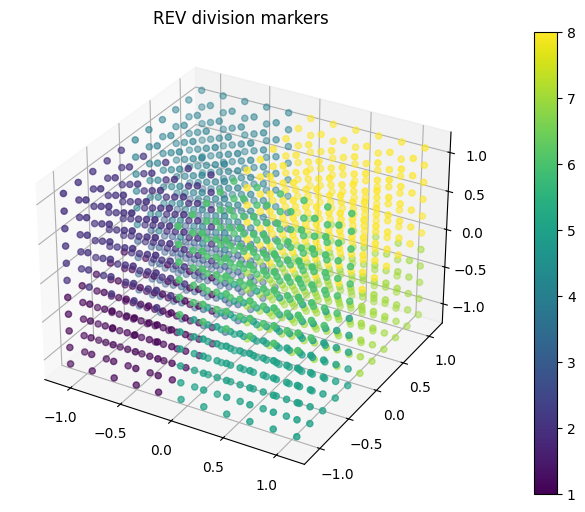

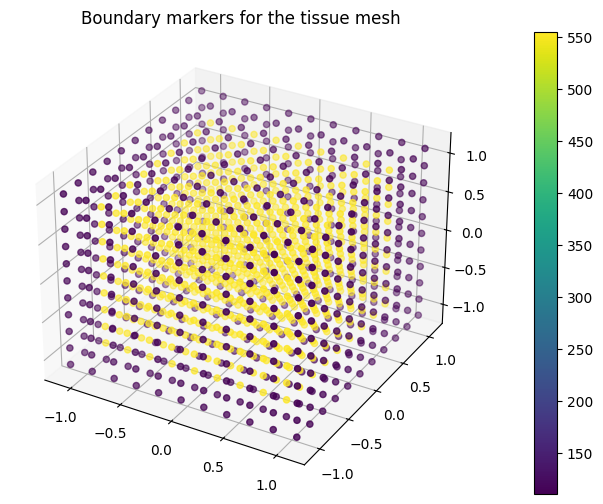

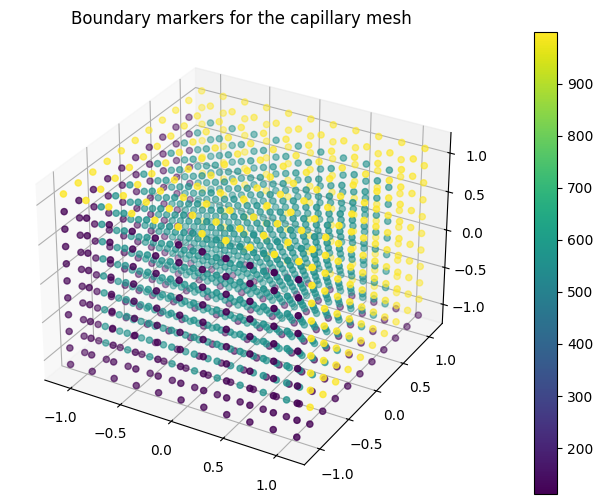

In [36]:
max_radius = 0.1
nn = 10

path_to_mesh = f'888_mesh/888_'

#--------------------------------------------------------------------

# # Get discrete system

beta_value = 0.001 # Neuman for tissue
p0_value=5000

nREV=8


meshV, Q_markers, V_markers, REV_markers_t = get_mesh(nn, max_radius,n_div_x,n_div_y,n_div_z)


In [37]:
start_time = time.time()
T, b, W = get_system(meshV, K_x, K_y, K_z, C, mu_bl_up, beta_value,p0_value)


print("\n------------------ System setup and assembly time: ", time.time() - start_time, "\n")


------------------ System setup and assembly time:  7.248287916183472 



Application of the Dirichlet boundary condition for the capillary

In [38]:
Q = FunctionSpace(meshV, 'CG', 1)

bc_in = [DirichletBC(Q, 7000, "on_boundary&&( (x[1]<-1.1+DOLFIN_EPS) || (x[0]<-1.1+DOLFIN_EPS) || (x[2]<-1.1+DOLFIN_EPS) )"), DirichletBC(Q, 5000, "on_boundary&&( (x[1]>1.1-DOLFIN_EPS) || (x[0]>1.1-DOLFIN_EPS) || (x[2]>1.1-DOLFIN_EPS))")]

bcs = block_bc([[],[], bc_in,[]], False)
#bcs = block_bc([[],[], bc_in,[]], False)
#bcs = block_bc([[],[]], False)
bcs.apply(T).apply(b)


[[],
 [],
 []]

Solving the Linear System

In [39]:
# convert matrix and vector to PETSc

b_PET = ii_convert(b)
shape = b_PET.size()  
A_PET = ii_convert(T).mat()
b_PET = b_PET.vec()
u     = np.zeros((shape))
tol   = 1e-15
u_PET = PETSc.Vec().createWithArray(u)

# Create a PETSc Krylov solver
solver = PETSc.KSP().create()
solver.setOperators(A_PET)
solver.setType(PETSc.KSP.Type.GMRES)  # <--Choose the solver type
solver.setFromOptions()  # <--Allow setting options from the command line or a file
solver.setTolerances(rtol=tol)
solver.setPCSide(1)
solver.view()

# Set preconditioner
pc = solver.getPC()
#pc.setType(PETSc.PC.Type.HYPRE)
#pc.setHYPREType("boomeramg")  # Set to use AMG
pc.setType(PETSc.PC.Type.ILU)
#c.setType(PETSc.PC.Type.NONE)
#pc.setType(PETSc.PC.Type.JACOBI)


solver.solve(b_PET, u_PET)

# print
print ('iterations = ',               solver.getIterationNumber())
print ('residual = ', '{:.2e}'.format(solver.getResidualNorm()))#  %.2E
print ('converge reason = ',          solver.getConvergedReason())
print ('residuals at each iter = ',   solver.getConvergenceHistory())
print ('precond type', pc.getType())
# Print solver information
num_iter = solver.getIterationNumber()
print(f"Number of iterations: {num_iter}")

KSP Object: 1 MPI process
  type: gmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with no iterative refinement
    happy breakdown tolerance 1e-30
  maximum iterations=10000, initial guess is zero
  tolerances:  relative=1e-15, absolute=1e-50, divergence=10000.
  right preconditioning
  using DEFAULT norm type for convergence test
PC Object: 1 MPI process
  type: ilu
  PC has not been set up so information may be incomplete
    out-of-place factorization
    0 levels of fill
    tolerance for zero pivot 2.22045e-14
    matrix ordering: natural
    matrix solver type: petsc
    matrix not yet factored; no additional information available
  linear system matrix = precond matrix:
  Mat Object: 1 MPI process
    type: seqaij
    rows=58228, cols=58228
    total: nonzeros=5430792, allocated nonzeros=5430792
    total number of mallocs used during MatSetValues calls=0
      using I-node routines: found 22948 nodes, limit used is 5
iterations =  47
residual =

Saving the results variables

In [40]:
V = VectorFunctionSpace(meshV, 'CG', 2,3)
Q = FunctionSpace(meshV, 'CG', 1)
dimV= V.dim()
dimQ= Q.dim()

ucap_pet_V = u_PET[:dimV]
ut_pet_V = u_PET[dimV: dimV+dimV]
pcap_pet_Q = u_PET[2*dimV: 2*dimV+dimQ]
pt_pet_Q = u_PET[2*dimV+dimQ:]

print(np.shape(ucap_pet_V))
print(np.shape(ut_pet_V))
print(np.shape(pcap_pet_Q))
print(np.shape(pt_pet_Q))

u_cap=Function(V)
u_t=Function(V)
p_cap=Function(Q)
p_t=Function(Q)


u_cap.vector()[:]=ucap_pet_V
u_t.vector()[:]=ut_pet_V
p_cap.vector()[:]=pcap_pet_Q
p_t.vector()[:]=pt_pet_Q


(27783,)
(27783,)
(1331,)
(1331,)


Text(0.5, 0.92, 'Tissue Pressure (Pa)')

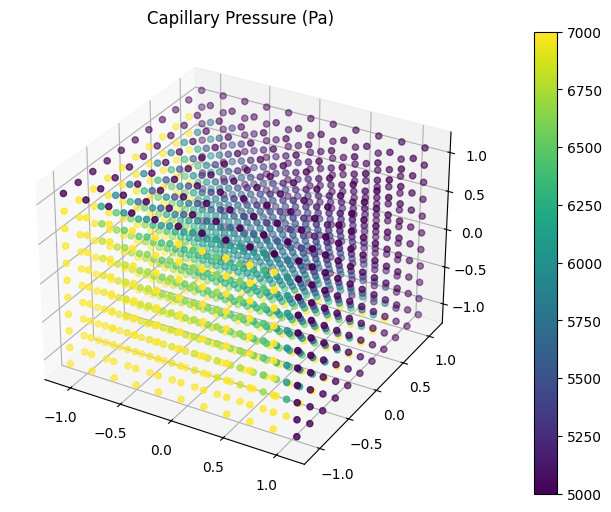

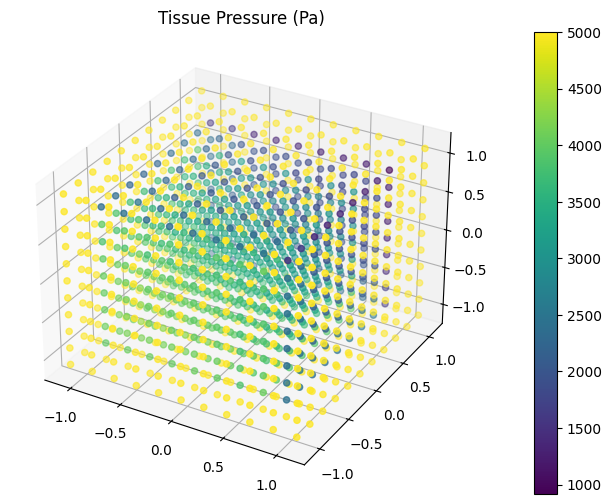

In [41]:
coord_V=meshV.coordinates()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=p_cap.compute_vertex_values(meshV))
cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
plt.title('Capillary Pressure (Pa)')


coord_V=meshV.coordinates()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=p_t.compute_vertex_values(meshV))
cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
plt.title('Tissue Pressure (Pa)')


In [42]:
#Saving

File(f'{dir_results}/FINAL_RESULTS/MARKERS/meshV.pvd') << meshV
File(f'{dir_results}/FINAL_RESULTS/PETSC/pcap_test_case_MIX.pvd') << p_cap
File(f'{dir_results}/FINAL_RESULTS/PETSC/pt_test_case_MIX.pvd') << p_t
File(f'{dir_results}/FINAL_RESULTS/PETSC/ucap_test_case_MIX.pvd') << u_cap
File(f'{dir_results}/FINAL_RESULTS/PETSC/ut_test_case_MIX.pvd') << u_t